In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scipy


from statsmodels.stats import weightstats as wsm
from statsmodels.stats.proportion import proportion_confint

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

В данном задании вам нужно будет

- проанализировать АБ тест, проведенный на реальных пользователях Яндекса
- подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
- определить характер этих изменений и практическую значимость вводимого изменения
- понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

Описание данных:
- userID: уникальный идентификатор пользователя
- browser: браузер, который использовал userID
- slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
- n_clicks: количество кликов, которые пользоваль совершил за n_queries
- n_queries: количество запросов, который совершил userID, пользуясь браузером browser
- n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [2]:
data = pd.read_csv('ab_browser_test.csv', sep=',')
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [3]:
data.browser = [int(data.browser[i][9:]) for i in range(data.shape[0])]

In [4]:
data.head(10)

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,2,exp,23,32,19
1,3,4,exp,3,4,2
2,5,4,exp,29,35,16
3,6,4,control,12,6,0
4,7,4,exp,54,68,30
5,8,4,control,4,4,1
6,9,4,exp,6,3,1
7,10,4,control,22,15,2
8,13,14,exp,2,4,3
9,15,14,control,2,2,0


Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.

In [5]:
exp = data[data.slot == 'exp']
control = data[data.slot == 'control']

exp_people = exp['slot'].value_counts()
control_people = control['slot'].value_counts()


In [6]:
exp_n_clics = exp.n_clicks.sum()
control_n_clics = control.n_clicks.sum()
print (round(((exp_n_clics / control_n_clics - 1) * 100),3))

1.614


In [7]:
print (exp_n_clics, control_n_clics)

3261823 3210027


Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
np.random.seed(0)

exp_n_clics_median_scores = list(map(np.median, get_bootstrap_samples(exp.n_clicks.values, 1000)))
control_n_clics_median_scores = list(map(np.median, get_bootstrap_samples(control.n_clicks.values, 1000)))

exp_n_clics_mean_scores = list(map(np.mean, get_bootstrap_samples(exp.n_clicks.values, 1000)))
control_n_clics_mean_scores = list(map(np.mean, get_bootstrap_samples(control.n_clicks.values, 1000)))

delta_median_scores = list(map(lambda x: x[0] - x[1], zip(exp_n_clics_median_scores, control_n_clics_median_scores)))
delta_mean_scores = list(map(lambda x: x[0] - x[1], zip(exp_n_clics_mean_scores, control_n_clics_mean_scores)))

print("95% доверительный интервал для median_exp:",  stat_intervals(exp_n_clics_median_scores, 0.05))
print("95% доверительный интервал для median_control:",  stat_intervals(control_n_clics_median_scores, 0.05))
print("95% доверительный интервал для разности медиан:",  stat_intervals(delta_median_scores, 0.05))
print('\n\n')
print("95% доверительный интервал для mean_exp:",  stat_intervals(exp_n_clics_mean_scores, 0.05))
print("95% доверительный интервал для mean_control:",  stat_intervals(control_n_clics_mean_scores, 0.05))
print("95% доверительный интервал для разности средних:",  stat_intervals(delta_mean_scores, 0.05))


95% доверительный интервал для median_exp: [5. 5.]
95% доверительный интервал для median_control: [4. 4.]
95% доверительный интервал для разности медиан: [1. 1.]



95% доверительный интервал для mean_exp: [11.50674915 11.65758017]
95% доверительный интервал для mean_control: [11.21242374 11.35449133]
95% доверительный интервал для разности средних: [0.19866114 0.40975645]


Ответ: не содержит 0 ни mean, ни median. Нельзя применять bootstrap.

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах.

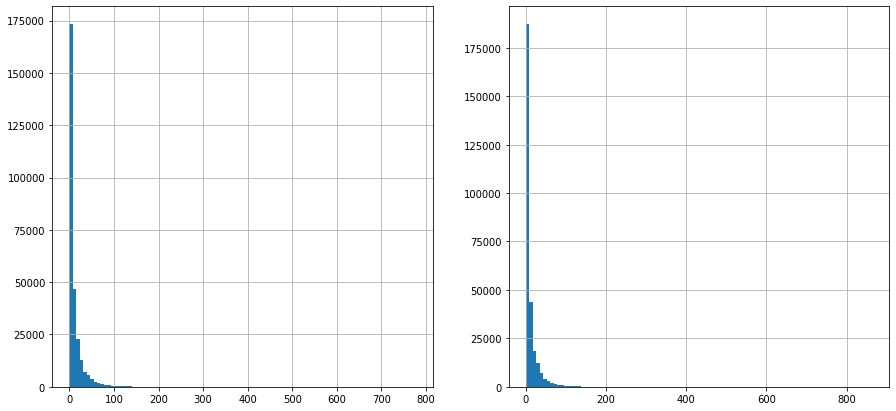

In [10]:
plt.figure(1,figsize=(15,7))
plt.subplot(121)
plt.hist(exp['n_clicks'],bins = 100)
plt.grid()
plt.subplot(122)
plt.hist(control['n_clicks'],bins = 100)
plt.grid()
plt.show()

t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Для простоты рассмотрим одновыборочный t-критерий. Чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

- среднее значение в выборке было распределено нормально N(μ,σ2n)
- несмещенная оценка дисперсии c масштабирующим коэффициентом была распределена по хи-квадрат c n−1 степенями свободы χ2(n−1)

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия.

Для этого
- получим из данных n_boot_samples псевдовыборок.
- по каждой из этих выборок посчитаем среднее и сумму квадратов отклонения от выборочного среднего
- для получившегося вектора средних значений из n_boot_samples построим q-q plot с помощью scipy.stats.probplot для нормального - распределения
- для получившегося вектора сумм квадратов отклонения от выборочного среднего построим qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения

In [11]:
control_n_clics_variation_scores = list(map(np.var, get_bootstrap_samples(control.n_clicks.values, 1000)))


Text(0.5, 1.0, 'Probability plot for var')

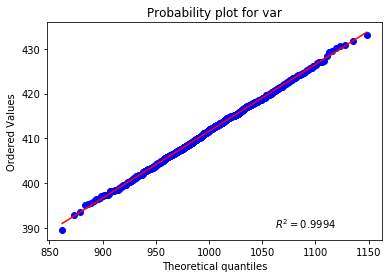

In [12]:
stats.probplot(control_n_clics_variation_scores, dist="chi2", 
                     sparams=(len(control_n_clics_mean_scores)-1), plot=plt,rvalue=True)
plt.title('Probability plot for var')

Text(0.5, 1.0, 'Probability plot for means')

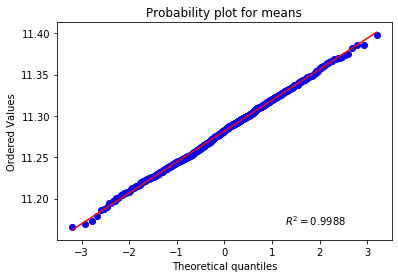

In [13]:
stats.probplot(control_n_clics_mean_scores, plot=plt, rvalue=True)
plt.title('Probability plot for means')

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [14]:
user_clics_exp = exp.groupby(['userID','browser']).sum().loc[:,'n_clicks']
user_clics_control = control.groupby(['userID','browser']).sum().loc[:,'n_clicks']
user_clics_control

userID  browser
6       4          12
8       4           4
10      4          22
15      14          2
23      4           3
                   ..
603128  14          5
603132  22          1
603133  14          1
603135  4           0
603136  4           2
Name: n_clicks, Length: 284554, dtype: int64

In [15]:
stats.mannwhitneyu(user_clics_exp, user_clics_control, alternative='two-sided')

MannwhitneyuResult(statistic=41184125116.0, pvalue=6.247235801369629e-75)

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с \alpha=0.05α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [16]:
browser_clics_exp = exp.groupby(['browser', 'userID']).sum().loc[:,'n_clicks']
browser_clics_control = control.groupby(['browser', 'userID']).sum().loc[:,'n_clicks']
browser_clics_control

browser  userID
2        29         9
         32         3
         60         5
         70         5
         73        13
                   ..
22       603121     0
         603123     1
         603124     4
         603125     1
         603132     1
Name: n_clicks, Length: 284554, dtype: int64

In [17]:
from statsmodels.sandbox.stats.multicomp import multipletests 

In [18]:
browsers = np.unique(data.browser)

print ('Критерий Манна-Уитни')
mw = np.empty(browsers.shape[0])
for i, br in enumerate(browsers):
    mw[i] = stats.mannwhitneyu(browser_clics_exp.loc[br,:], browser_clics_control.loc[br,:], alternative='two-sided')[1]
    print ('Browser #', br,
           'p-value', mw[i])

print ('Критерий Манна-Уитни с поправкой Холма-Бонферрони')
mw_corr =  multipletests(mw,alpha = 0.05,method = 'holm')[1]
for i, br in enumerate(browsers):
    print ('Browser #', br,
           'p-value',mw_corr[i] )


Критерий Манна-Уитни
Browser # 2 p-value 0.0544877208394482
Browser # 4 p-value 0.8152123531690997
Browser # 14 p-value 0.0
Browser # 17 p-value 0.07480120286021603
Browser # 20 p-value 0.9073331277747075
Browser # 22 p-value 0.5148110304420064
Критерий Манна-Уитни с поправкой Холма-Бонферрони
Browser # 2 p-value 0.27243860419724103
Browser # 4 p-value 1.0
Browser # 14 p-value 0.0
Browser # 17 p-value 0.29920481144086414
Browser # 20 p-value 1.0
Browser # 22 p-value 1.0


In [19]:

browsers_nonclk_q_exp = exp.groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_exp = exp.groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_exp = browsers_nonclk_q_exp / browsers_clk_q_exp

browsers_nonclk_q_ctrl = control.groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_ctrl = control.groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_ctrl = browsers_nonclk_q_ctrl / browsers_clk_q_ctrl

print('Control / experimental groups')
for br in browsers:
    print('Browser #%d' % br, browsers_nonclk_q_prop_ctrl.loc[browsers_nonclk_q_prop_ctrl.index == br].values, '/', 
          browsers_nonclk_q_prop_exp.loc[browsers_nonclk_q_prop_ctrl.index == br].values)
   

Control / experimental groups
Browser #2 [0.45962747] / [0.44982747]
Browser #4 [0.4697093] / [0.45142942]
Browser #14 [0.57590411] / [0.43755617]
Browser #17 [0.36299367] / [0.36937413]
Browser #20 [0.40540485] / [0.38977376]
Browser #22 [0.40593977] / [0.39853947]
